In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

In [2]:
stock_df = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
stock_df.to_csv("APPl_data.csv")

[*********************100%***********************]  1 of 1 completed


In [3]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  3522 non-null   float64
 1   (Close, AAPL)      3522 non-null   float64
 2   (High, AAPL)       3522 non-null   float64
 3   (Low, AAPL)        3522 non-null   float64
 4   (Open, AAPL)       3522 non-null   float64
 5   (Volume, AAPL)     3522 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.6 KB


In [4]:
stock_df.columns = [' '.join(col).strip() for col in stock_df.columns]
stock_df.reset_index(inplace=True)

In [5]:
stock_df.rename(columns={'Volume AAPL': 'Volume',
                           'Adj Close AAPL': 'Adj Close',
                           'Close AAPL': 'Close',
                           'High AAPL':'High',
                           'Low AAPL':'Low',
                           'Open AAPL':'Open'
                          }, inplace=True)


In [6]:
stock_df['Ordinal_Date']=stock_df['Date'].apply(lambda x: x.toordinal())

In [7]:
stock_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Ordinal_Date
0,2010-01-04,6.447412,7.643214,7.660714,7.585000,7.622500,493729600,733776
1,2010-01-05,6.458560,7.656429,7.699643,7.616071,7.664286,601904800,733777
2,2010-01-06,6.355829,7.534643,7.686786,7.526786,7.656429,552160000,733778
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200,733779
4,2010-01-08,6.386255,7.570714,7.571429,7.466429,7.510714,447610800,733780


In [8]:
# Extract temporal features
stock_df['day_of_week'] = stock_df['Date'].dt.dayofweek  # Monday=0, Sunday=6
stock_df['month'] = stock_df['Date'].dt.month
stock_df['day_of_year'] = stock_df['Date'].dt.dayofyear

# Cyclic features
stock_df['day_sin'] = np.sin(2 * np.pi * stock_df['day_of_year'] / 365)
stock_df['day_cos'] = np.cos(2 * np.pi * stock_df['day_of_year'] / 365)

# Ordinal trend
stock_df['date_trend'] = stock_df['Date'].apply(lambda x: x.toordinal())

In [9]:
stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()          #SMA with 20 day rolling window
stock_df['EMA_20'] = stock_df['Close'].ewm(span=20, adjust=False).mean()  #EMA with 20 day rolling window
delta =stock_df['Close'].diff()

gain = delta.where(delta > 0, 0 )
loss = delta.where(delta<0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()



rs = avg_gain/avg_loss



stock_df['RSI'] = 100 - (100 / (1 + rs))

stock_df['Middle_Band'] =stock_df['Close'].rolling(window=20).mean()
stock_df['std'] = stock_df['Close'].rolling(window=20).std()
stock_df['Upper_Band'] = stock_df['Middle_Band'] + 2 * stock_df['std']
stock_df['Lower_Band'] = stock_df['Middle_Band'] - 2 * stock_df['std']

In [10]:
stock_df['RMF']= ((stock_df['High'] +stock_df['Low'] + stock_df['Close']) / 3) * stock_df['Volume']

In [14]:
stock_df['Typcal_Price'] = (stock_df['High'] +stock_df['Low'] + stock_df['Close']) / 3
stock_df['MF_positive']=np.where(stock_df['Typcal_Price'].diff()>0, stock_df['RMF'],0)
stock_df['MF_negative']=np.where(stock_df['Typcal_Price'].diff()<0, stock_df['RMF'],0)



#Money Flow Index MFI
positive_sum =stock_df['MF_positive'].rolling(window=14).sum()
negative_sum =stock_df['MF_negative'].rolling(window=14).sum()

m_ratio = positive_sum / negative_sum
stock_df['MFI'] = 100 - (100/(1+m_ratio))

In [15]:
scaler = MinMaxScaler()
stock_df['Volume_normalized'] = scaler.fit_transform(stock_df[['Volume']])

In [16]:
stock_df.dropna(inplace=True)  


In [17]:
corr_matrix = stock_df.corr()
corr_matrix['Adj Close']

Date                 0.885349
Adj Close            1.000000
Close                0.999951
High                 0.999833
Low                  0.999851
Open                 0.999716
Volume              -0.531531
Ordinal_Date         0.885349
day_of_week          0.001808
month                0.068728
day_of_year          0.068632
day_sin             -0.063971
day_cos              0.010455
date_trend           0.885349
SMA_20               0.998064
EMA_20               0.998604
RSI                  0.006671
Middle_Band          0.998064
std                  0.845203
Upper_Band           0.997421
Lower_Band           0.997290
RMF                  0.534678
Typcal_Price         0.999918
MF_positive          0.261081
MF_negative          0.229052
MFI                 -0.014941
Volume_normalized   -0.531531
Name: Adj Close, dtype: float64

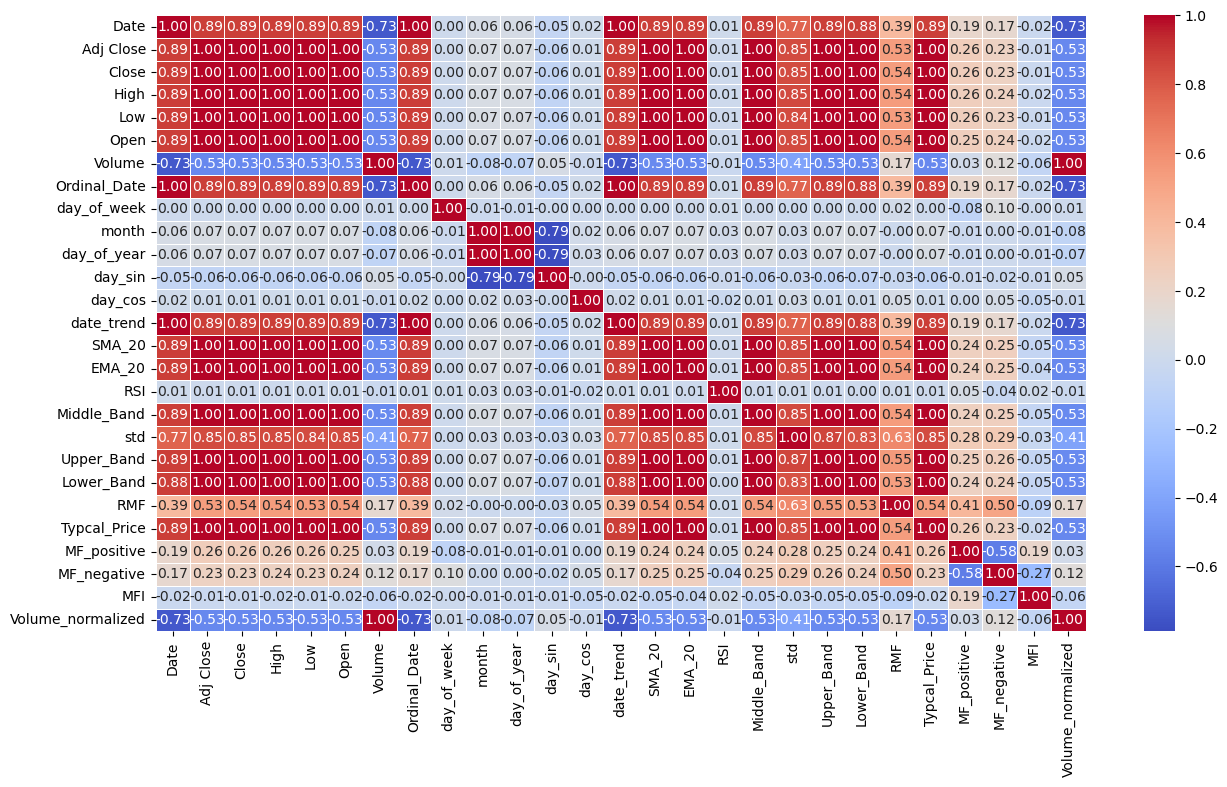

In [18]:
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

In [70]:
corr_features = corr_matrix.index[corr_matrix['Adj Close'] > 0.9].tolist()
corr_features

['Adj Close',
 'Close',
 'High',
 'Low',
 'Open',
 'SMA_20',
 'EMA_20',
 'Middle_Band',
 'Upper_Band',
 'Lower_Band',
 'Typcal_Price']

In [84]:
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


        Feature  Importance
2           Low    0.615269
0          High    0.224880
1          Open    0.094528
10   Upper_Band    0.022619
4        EMA_20    0.015256
7   Middle_Band    0.015155
5        SMA_20    0.012175
3    Lower_Band    0.000052
9        Volume    0.000025
6           RMF    0.000023
8   MF_positive    0.000018


In [96]:
numeric_features = ['High','Low','Open','SMA_20','EMA_20','Middle_Band', 'Upper_Band', 'Lower_Band',]
date_feature = ['Date']
target_feature=['Adj Close']

X = stock_df[numeric_features]
y = stock_df[target_feature]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [86]:
pre_process=ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),numeric_features)
    ],
    remainder='passthrough')

In [87]:
random_forest=RandomForestRegressor(random_state=42)

In [88]:
pipe_line=Pipeline( [('preprocessor', pre_process) , ('model', random_forest)] )

In [89]:
hyper_param_grid= {
    'model__n_estimators': [50,200,300],   #number of trees in the forest
    'model__max_depth': [10,20,30],         #maximum depth of each tree
    'model__min_samples_split': [5,10,20], #minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1,5,9]   #minimum number of samples required to be at a leaf node
}

In [90]:
hyper_param_grid

{'model__n_estimators': [50, 200, 300],
 'model__max_depth': [10, 20, 30],
 'model__min_samples_split': [5, 10, 20],
 'model__min_samples_leaf': [1, 5, 9]}

In [91]:
#class sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)

In [92]:
grid_search=GridSearchCV(pipe_line, hyper_param_grid, n_jobs= -1, cv= 5, verbose=1)

In [93]:
print(RandomForestRegressor().get_params().keys())


dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [100]:
X_train.isnull().sum()

High           0
Low            0
Open           0
SMA_20         0
EMA_20         0
Middle_Band    0
Upper_Band     0
Lower_Band     0
dtype: int64

In [94]:
grid_search.fit(X_train, y_train)

best_model= grid_search.best_estimator_
y_pred= best_model.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [95]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Mean Squared Error: 652.1006329600491
R² Score: -0.740435605091645


In [17]:
features = ['High', 'Low', 'Open', 'Volume', 'SMA_20', 'EMA_20',
            'Lower_Band', 'Middle_Band', 'Upper_Band',
            'date_trend']  
target = 'Adj Close'  

In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)


rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 653.402990227448
R² Score: -0.7439115169935564
